### Reading and Understanding Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import datetime as dt
    

In [5]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree


In [7]:
retail_data=pd.read_csv("Online_Retail.csv",encoding="ISO-8859-1")

In [8]:
retail_data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [11]:
retail_data.shape

(541909, 8)

In [12]:
retail_data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [13]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Data Cleansing

In [15]:
# Calculating missing value % contribution in Dataframe

df_null=round(100*(retail_data.isnull().sum())/len(retail_data),2)

df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [18]:
retail_data=retail_data.dropna()

retail_data.shape

(406829, 8)

In [19]:
retail_data.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [20]:
retail_data['CustomerID']=retail_data['CustomerID'].astype(str)

### Data Preparation

In [23]:
### Main 3 factors will cover:-Number of days since last purchase,Number of tracsactions,Total amount of transactions (revenue contributed)

###Creating new calculated column:Amount
retail_data['Amount']=retail_data['Quantity']*retail_data['UnitPrice']


revenue_per_customer=retail_data.groupby('CustomerID')['Amount'].sum()
revenue_per_customer=revenue_per_customer.reset_index()
revenue_per_customer.head(15)


,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
5,12352.0,1545.41
6,12353.0,89.00
7,12354.0,1079.40
8,12355.0,459.40
9,12356.0,2811.43


In [24]:
## Frequency:Number of transaction per customer

no_of_transaction=retail_data.groupby('CustomerID')['InvoiceNo'].count()
no_of_transaction=no_of_transaction.reset_index()
no_of_transaction.columns=['CustomerID','Frequency']
no_of_transaction

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4367,18280.0,10
4368,18281.0,7
4369,18282.0,13
4370,18283.0,756


In [25]:
## Merging two dfs

amount_transaction_per_customer=pd.merge(revenue_per_customer,no_of_transaction,on='CustomerID',how='inner')
amount_transaction_per_customer.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [26]:
### Converting datetime to proper datatype

retail_data['InvoiceDate']=pd.to_datetime(retail_data['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [27]:
max_date=max(retail_data['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [31]:
retail_data['Difference']=max_date-retail_data['InvoiceDate']
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Dfiiference,Difference
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00,373 days 04:24:00


In [32]:
### Compute last transaction date to get the recency of customers

last_transaction_date=retail_data.groupby('CustomerID')['Difference'].min()
last_transaction_date=last_transaction_date.reset_index()
last_transaction_date.head()

,CustomerID,Difference
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [33]:
## Extract only days
last_transaction_date['Difference']=last_transaction_date['Difference'].dt.days

last_transaction_date.head()


,CustomerID,Difference
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [34]:
### Merage all 3 dataframe

amount_transaction_per_customer=pd.merge(amount_transaction_per_customer,last_transaction_date,on='CustomerID',how='inner')
amount_transaction_per_customer.columns=['CustomerID', 'Amount', 'Frequency', 'Regency']

In [35]:
amount_transaction_per_customer.head()

,CustomerID,Amount,Frequency,Regency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

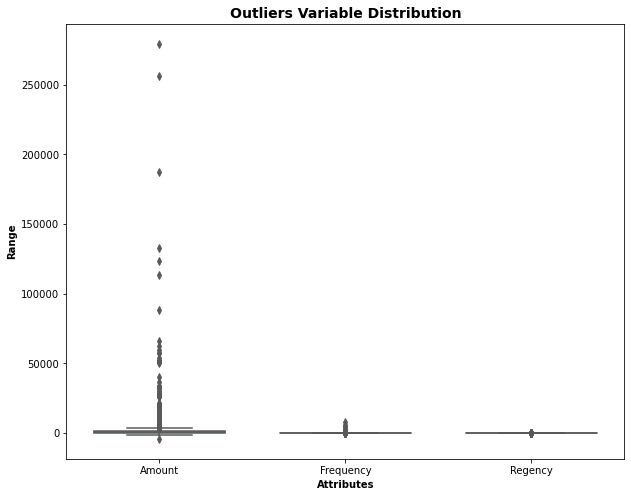

In [36]:
## Outlier Analysis of amount Frequency and Recency

attributes=['Amount', 'Frequency', 'Regency']
plt.rcParams['figure.figsize']=[10,8]
sns.boxplot(data=amount_transaction_per_customer[attributes],orient="v",palette="Set2",whis=1.5,saturation=1,width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [38]:
### Removing Outliers for Amount

Q1=amount_transaction_per_customer.Amount.quantile(0.05)
Q3=amount_transaction_per_customer.Amount.quantile(0.95)

IQR=Q3-Q1
amount_transaction_per_customer=amount_transaction_per_customer[(amount_transaction_per_customer.Amount>=Q1-1.5*IQR) & amount_transaction_per_customer.Amount<Q3+1.5*IQR]


Q1=amount_transaction_per_customer.Regency.quantile(0.05)
Q3=amount_transaction_per_customer.Regency.quantile(0.95)

IQR=Q3-Q1
amount_transaction_per_customer=amount_transaction_per_customer[(amount_transaction_per_customer.Regency>=Q1-1.5*IQR) & amount_transaction_per_customer.Regency<Q3+1.5*IQR]

Q1=amount_transaction_per_customer.Frequency.quantile(0.05)
Q3=amount_transaction_per_customer.Frequency.quantile(0.95)

IQR=Q3-Q1
amount_transaction_per_customer=amount_transaction_per_customer[(amount_transaction_per_customer.Frequency>=Q1-1.5*IQR) & amount_transaction_per_customer.Frequency<Q3+1.5*IQR]


In [39]:
## rescaling the attributes


rfm_df=amount_transaction_per_customer[['Amount','Frequency','Regency']]

#Instantiate

scaler=StandardScaler()
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape


(4372, 3)

In [40]:
rfm_df_scaled=pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns=['Amount','Frequency','Regency']
rfm_df_scaled.head()

,Amount,Frequency,Regency
0,-0.231001,-0.391720,2.322023
1,0.293432,0.382657,-0.893733
2,-0.012316,-0.266959,-0.169196
3,-0.017146,-0.086271,-0.725005
4,-0.190312,-0.327188,2.163220


### Building Model

In [43]:
Kmeans= KMeans(n_clusters=4,max_iter=50)
Kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [44]:
Kmeans.labels_

array([1, 0, 0, ..., 0, 0, 0])

In [45]:
### Finding the Optimal number of cluster

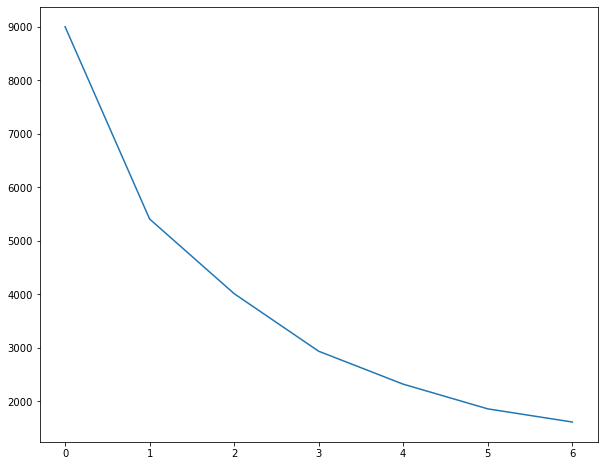

In [49]:
ssd=[]

range_n_clusters=[2,3,4,5,6,7,8]

for num_clusters in range_n_clusters:
    Kmeans = KMeans(n_clusters=num_clusters,max_iter=50)
    Kmeans.fit(rfm_df_scaled)
    
    ssd.append(Kmeans.inertia_)
    
plt.plot(ssd)

In [52]:
## Silhouette analysis

range_n_clusters=[2,3,4,5,6,7,8]

for num_clusters in range_n_clusters:
    Kmeans=KMeans(n_clusters=num_clusters,max_iter=50)
    Kmeans.fit(rfm_df_scaled)
    
    cluster_labels=Kmeans.labels_
    
    
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.9344641162235822
For n_clusters=3, the silhouette score is 0.6003883114752382
For n_clusters=4, the silhouette score is 0.5982147807169456
For n_clusters=5, the silhouette score is 0.6148206579543399
For n_clusters=6, the silhouette score is 0.5856955818362631
For n_clusters=7, the silhouette score is 0.527690115144751
For n_clusters=8, the silhouette score is 0.5010660318434227


In [53]:
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [54]:
Kmeans.labels_

array([1, 6, 7, ..., 7, 3, 7])

In [55]:
amount_transaction_per_customer['Cluster_Id'] = kmeans.labels_
amount_transaction_per_customer.head()

,CustomerID,Amount,Frequency,Regency,Cluster_Id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

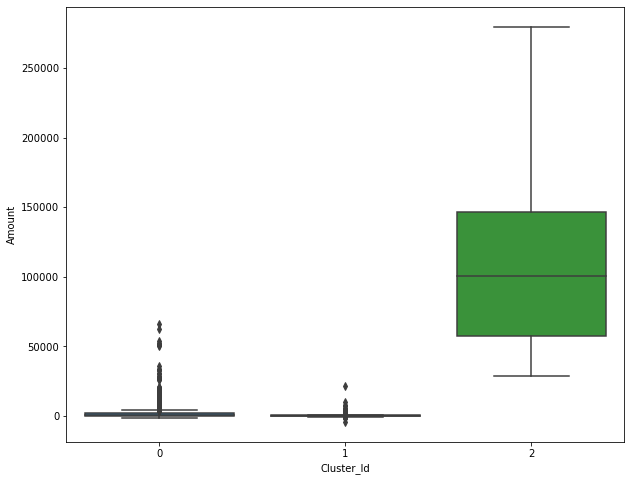

In [56]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Amount', data=amount_transaction_per_customer)


<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

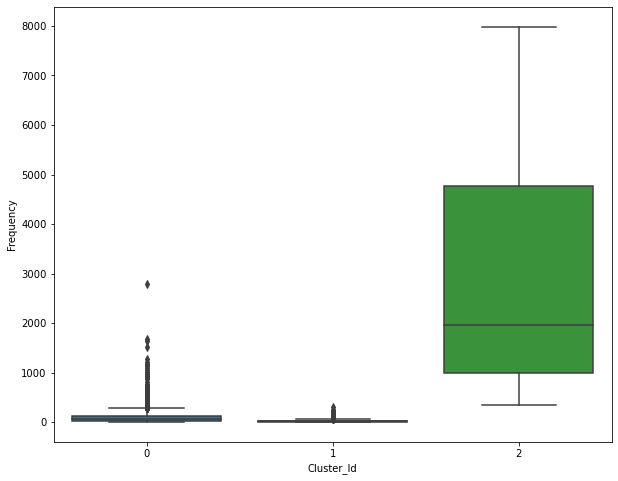

In [57]:
# Box plot to visualize Cluster Id vs Frequency

sns.boxplot(x='Cluster_Id', y='Frequency', data=amount_transaction_per_customer)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Regency'>

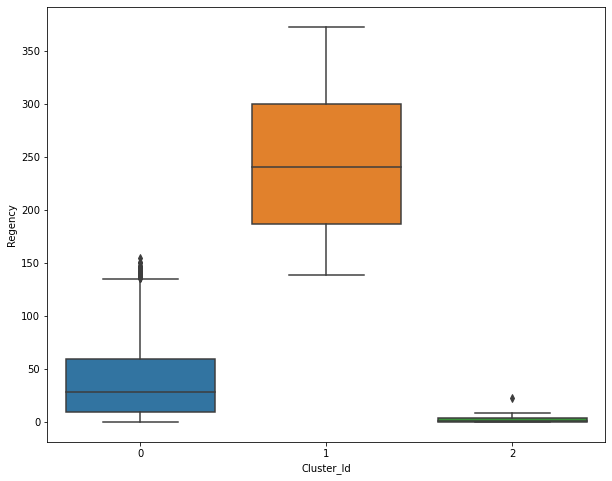

In [59]:
# Box plot to visualize Cluster Id vs Recency

sns.boxplot(x='Cluster_Id', y='Regency', data=amount_transaction_per_customer)